This notebook demonstrates the usage of the resilience/socio-economic capacity model.

# Loading functions

We first import function librairies. The first ones are standard python librairies.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#The main library we use. Manipulates Excel-like tables (called dataframes) with named rows and columns
import pandas as pd 
import numpy as np

In [3]:
#ploting capacities
import matplotlib.pyplot as plt 
#make plots appear in this notebook
%matplotlib inline  

#Default options for plots: this controls the font used in figures
font = {'family' : 'sans serif',
    'size'   : 18}
plt.rc('font', **font)


# Loading socio-economic data

Here we read the data set we need into a pandas table (called DataFrame).
This specific dataset was put together from a variety of different sources using another python notebook: [data_gathering_demo.ipynb](data_gathering_demo.ipynb). In the future we could build directly an excel file with all the data the model needs.

In [4]:
#Let's first have a look at the Excel file
df=pd.read_excel("inputs/PSA_compiled.xlsx",skiprows=1, index_col=0)
df.index.name="province"

#Expresses income in thousands
df[["cp","cr","gdp_pc_pp"]]/=1e3

df.head()

,pop,cp,cr,pov_head,gdp_pc_pp,shewp,shewr,social_p,social_r
province,,,,,,,,,
Abra,51167,92.828972,203.891421,0.271937,173.689487,0.063163,0.173531,0.173531,0.203457
Agusan del Norte,141357,82.348426,234.816324,0.276778,192.616487,0.249100,0.147336,0.147336,0.226521
Agusan del Sur,141595,83.304081,216.087522,0.372958,166.564929,0.139189,0.126444,0.126444,0.113334
Aklan,123269,79.445859,211.619510,0.204461,184.595206,0.128517,0.184183,0.184183,0.239542
Albay,267030,76.582210,224.008585,0.339106,174.015387,0.172775,0.201804,0.201804,0.213554


In [5]:
df["gdp_pc_pp_nat"] = np.average(df.dropna()["gdp_pc_pp"],weights=df.dropna()["pop"])
df.gdp_pc_pp_nat.head()

province
Abra                234.602577
Agusan del Norte    234.602577
Agusan del Sur      234.602577
Aklan               234.602577
Albay               234.602577
Name: gdp_pc_pp_nat, dtype: float64

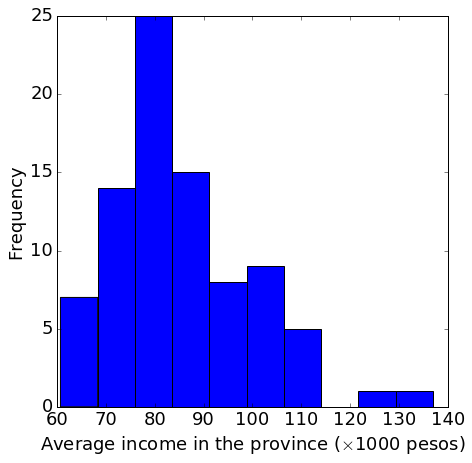

In [6]:
df.cp.plot.hist(figsize=(7,7))
plt.xlabel("Average income in the province ($\\times$1000 pesos)");

# Loading materials data

In [7]:
#Reduced vulnerability function for walls and roofs

In [8]:
roof_v = pd.read_csv("inputs/roof_types_to_vuln.csv").squeeze()
wall_v = pd.read_csv("inputs/wall_types_to_vuln.csv").squeeze()
wall_v

Wall_Strong material(galvanized,iron,al,tile,concrete,brick,stone,asbestos)    0.1
Wall_Light material                                                            0.4
Wall_Salvaged/makeshift materials                                              0.7
Wall_Mixed but predominantly strong materials                                  0.1
Wall_Mixed but predominantly light materials                                   0.4
Wall_Mixed but predominantly salvaged materials                                0.7
Name: 0, dtype: float64

In [9]:
#asset vulnerabily as a weighted average

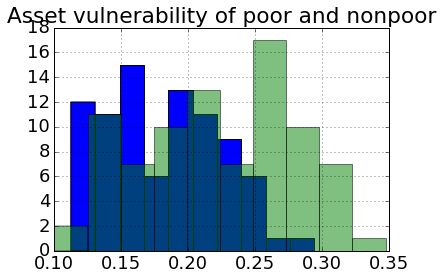

In [10]:
poorroof = pd.read_excel("inputs/PSA_materials.xlsx", sheetname="Prop_Roof_Poor", skiprows=[1], index_col=0)
poorwall = pd.read_excel("inputs/PSA_materials.xlsx", sheetname="Prop_Wall_Poor", skiprows=[1], index_col=0)

df["v_p"] = (poorwall.mul(wall_v).sum(axis=1) + poorroof.mul(roof_v).sum(axis=1) )/2

nonpoorroof = pd.read_excel("inputs/PSA_materials.xlsx", sheetname="Prop_Roof_Non-poor", skiprows=[1], index_col=0)
nonpoorwall = pd.read_excel("inputs/PSA_materials.xlsx", sheetname="Prop_Wall_Non-poor", skiprows=[1], index_col=0)

df["v_r"] = (nonpoorwall.mul(wall_v).sum(axis=1) + poorroof.mul(roof_v).sum(axis=1) )/2

ax=df[["v_r"]].hist()
ax=df[["v_p"]].hist(ax=ax, alpha=0.5)
plt.title("Asset vulnerability of poor and nonpoor")

# Data on hazard (coastal floods)

So far, we do not ave access to hazard data. We thus use hazard estimates based on global models for illustration pusposes. 
(Estimates of socio-economic capacity are fairly independent from hazard estimates)

In [11]:
#WB unofficial estimates
expo = pd.read_csv('inputs/exposure_to_coastal_foods.csv', index_col=0)
df["fap"] =expo["fap"].clip_lower(0.5/100)
df["far"] =expo["far"].clip_lower(0.5/100)

#Estimates from FLOPROS
df["protection"]=pd.read_csv("inputs/protection_phl.csv", index_col=0).clip_lower(1)

#Fills data gaps with averages (again for illsutrative purposes)
df[["fap", "far", "protection"]] = df[["fap", "far", "protection"]].fillna(df[["fap", "far", "protection"]].mean())

# Manually filling data gaps and informing parameters

Some data is missing and has to be added manually

In [12]:
#average productivity of capital
df["avg_prod_k"] = .23

#Reconstruction time (an only be guessed ex-ante)
df["T_rebuild_K"] = 3

# how much early warning reduces vulnerability (eg reactivity to early warnings)
df["pi"] = 0.2

Some other inputs are normative or policy choices

In [13]:
#scale up of transfers after a disaster hits
df["sigma_r"]=df["sigma_p"]=0

#income elasticity
df["income_elast"] = 1.5

#discount rate
df["rho"]=15/100

# Saves all data compiled

In [14]:
description = pd.read_csv("inputs/inputs_info.csv", index_col="key")["descriptor"]
description.head()

data = df.copy()
data.ix["description"]= description
data=data.T.reset_index().set_index(["description","index"]).T
data.columns.names = ['description', 'variable']

#saves the data
data.to_excel("inputs/all_data_compiled.xlsx")

data.head().T #displays the first few provinces, transposed for ease of reading.

,province,Abra,Agusan del Norte,Agusan del Sur,Aklan,Albay
description,variable,,,,,
Population,pop,51167,141357,141595,123269,267030
Average income of poor families,cp,92.829,82.3484,83.3041,79.4459,76.5822
Average income of non poor families,cr,203.891,234.816,216.088,211.62,224.009
Poverty incidence,pov_head,0.271937,0.276778,0.372958,0.204461,0.339106
Average income in the province,gdp_pc_pp,173.689,192.616,166.565,184.595,174.015
Access to early warning for poor people,shewp,0.0631627,0.2491,0.139189,0.128517,0.172775
Access to early warning for nonpoor people,shewr,0.173531,0.147336,0.126444,0.184183,0.201804
Social protection for poor people,social_p,0.173531,0.147336,0.126444,0.184183,0.201804
Social protection for non-poor people,social_r,0.203457,0.226521,0.113334,0.239542,0.213554


# Computing socio-economic capacity

Now that we have minimum familiarity with dataframes, let us use the resilience model. Let us first read the function definitions, from [res_ind_lib.py](res_ind_lib.py)

#### Loading functions

In [15]:
from res_ind_lib import *     #MAIN library: the functions used to compute risk, resilience, etc

#### Defining reference variabes

Before running the model, for technical reasons, we need to define "reference" values for some variables. The following function does it.

In [16]:
df = def_ref_values(df)

#### Assessing risk to assets, capacity, and risk to welfare

The function compute_resiliences computes risk and capacity from all the data.

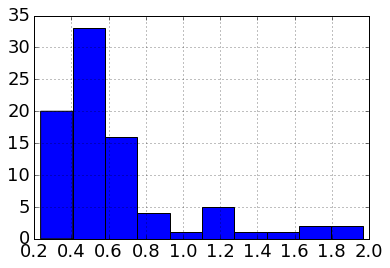

In [17]:
df_with_results=compute_resiliences(df)
df_with_results.resilience.hist()

Let us look at a few inputs and outputs of that function

Now we add a description to each column (from [inputs/inputs_info.csv](inputs/inputs_info.csv)) and save the resulting table

In [18]:
#read descritpion of each variable
description = pd.read_csv("inputs/inputs_info.csv", index_col="key")["descriptor"]
description.head()

#copy of the results
data = df_with_results.copy()

#adds description line
data.ix["description"]= description

#makes that line part of the index
data=data.T.reset_index().set_index(["description","index"]).T
data.columns.names = ['description', 'variable']

#exports the result to a CSV file
data.to_csv("results/all_data_and_results.csv") #we call that file _simple because it does not rely on multihazard data

#displays the first few provinces, transposed for ease of reading.
data.head().T

,province,Abra,Agusan del Norte,Agusan del Sur,Aklan,Albay
description,variable,,,,,
Population,pop,51167,141357,141595,123269,267030
Average income of poor families,cp,92.829,82.3484,83.3041,79.4459,76.5822
Average income of non poor families,cr,203.891,234.816,216.088,211.62,224.009
Poverty incidence,pov_head,0.271937,0.276778,0.372958,0.204461,0.339106
Average income in the province,gdp_pc_pp,173.689,192.616,166.565,184.595,174.015
Access to early warning for poor people,shewp,0.0631627,0.2491,0.139189,0.128517,0.172775
Access to early warning for nonpoor people,shewr,0.173531,0.147336,0.126444,0.184183,0.201804
Social protection for poor people,social_p,0.173531,0.147336,0.126444,0.184183,0.201804
Social protection for non-poor people,social_r,0.203457,0.226521,0.113334,0.239542,0.213554


#### Visualizing risk to assets, capacity and risk to welfare

Now we visualize risk and resilience acrross provinces, with plots and maps

Socio-economic capacity can also be visualized in a map (see [draw_maps.ipynb](draw_maps.ipynb) for how to build these maps)

Socio-economic capacity averages 63% across our sample, ranging from 23% to 197%


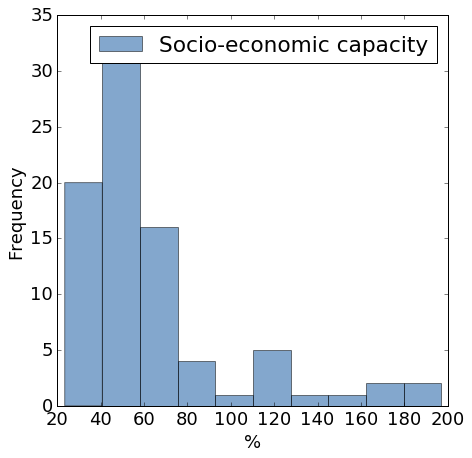

In [19]:
a=df_with_results["resilience"];
a.min()*100,a.mean()*100,a.max()*100
print("Socio-economic capacity averages {mean:.0%} across our sample, ranging from {min:.0%} to {max:.0%}".format(
    min=a.min(),mean=a.mean(),max=a.max()))
plt.figure(figsize=(7,7))
ax2=(100*a).plot.hist(alpha=0.5, color="#08519c");
ax2.legend(["Socio-economic capacity"])
ax2.set_xlabel('%');


![title](img/map_and_legend_of_se_capacity.png)

# Categorizing provinces

Here we categorize provinces in 3 tiers (Low, mid, high) according to their ranking on socio-econic capacity and on overall risk to welfare. We use the functions `make_tiers` and `categories_to_formated_excel_file` from [res_ind_lib.py](res_ind_lib.py)

In [20]:
from categorize import *

In [21]:
categories = pd.DataFrame([make_tiers(df_with_results.resilience)
                           ]).T.dropna()

categories.rename(columns=description).head()

,Socio-economic capacity
province,
Zamboanga Sibugay,Low
Maguindanao,Low
Masbate,Low
Misamis Occidental,Low
Negros Occidental,Low


# Policy experiments

Finally, the resilience indicator model can be used to asses the impact of specific policies on asset and welfare losses. In the following we provide two examples. More policy assessment are performed in [render_policy_assessment.ipynb](render_policy_assessment.ipynb)

#### Impact of increasing the income of poor families

In [22]:
df_share1 = compute_resiliences( def_ref_values(df.dropna().assign(cp=df.cp*1.05) ))

#welfare losses
wa=df_with_results.dWtot_currency.sum()*1e-6
wb=df_share1.dWtot_currency.sum()*1e-6

#asset losses
ka = (df_with_results.dKtot).sum()*1e-6
kb = (df_share1.dKtot).sum()*1e-6

nb_countries_all_results = df_with_results["resilience"].dropna().shape[0]

print(" Increasing the income of poor households by 5 percent in the {nb} provincies \
would increase asset losses from {ka:0.2f} to {kb:0.2f} billions per year\
 ({XX:.1%}), but reduce welfare losses by {YY:.1%}".format(
        XX=(kb-ka)/ka,ka=ka,kb=kb,YY=(wa-wb)/wa,nb=nb_countries_all_results)
     )

 Increasing the income of poor households by 5 percent in the 85 provincies would increase asset losses from 56.54 to 56.93 billions per year (0.7%), but reduce welfare losses by 1.1%


#### Impact of scaling up social protection

In [23]:
df_su = compute_resiliences( df.dropna().assign(sigma_p=.33,sigma_r=0.33) )

#welfare losses
wa=df_with_results.dWtot_currency.sum()*1e-6
wb=df_su.dWtot_currency.sum()*1e-6

#asset losses
ka = (df_with_results.dKtot).sum()*1e-6
kb = (df_su.dKtot).sum()*1e-6

print("Scaling up social protection to cover one third of asset losses in the {nb} provincies \
would left asset losses unchanged (from {ka:0.2f} to {kb:0.2f} billions per year), \
but reduce welfare losses by {YY:.0%}".format(
        XX=100*(kb-ka)/ka,ka=ka,kb=kb,YY=(wb-wa)/wb,nb=nb_countries_all_results)
     )

Scaling up social protection to cover one third of asset losses in the 85 provincies would left asset losses unchanged (from 56.54 to 56.54 billions per year), but reduce welfare losses by -7%


In [24]:
def write_missing_data(s):
    which = s[s.isnull()].index.values
    return ", ".join(which)

def count_missing_data(s):
    return s.isnull().sum()

report = pd.DataFrame()

report["nb_missing"]=df.apply(count_missing_data,axis=1)  
report["missing_data"]=df.apply(write_missing_data,axis=1)

report  = report.ix[report["nb_missing"]>0,:]
report.sort_values(by="nb_missing",inplace=True)
report.to_csv("inputs/missing_data_report.csv")

report

,nb_missing,missing_data
province,,
